<img src="AW&H2015.tiff" style="float: left">

<img src="flopylogo.png" style="float: center">

# Problem P5.1 Island Recharge Grid Sensitivity

In Problem P5.1 from pages 244-245 in Anderson, Woessner and Hunt (2015), we are asked to construct an areal 2D model to assess impacts of grid sensitivity on pumping.  Develop a 2D areal model using Flopy to solve for heads in the upper right-hand quadrant of the island shown in Fig. P5.1. The aquifer is confined, homogeneous, and isotropic with transmissivity, T, equal to 10,000 ft2/day. Recharge, R, occurs uniformly through a leaky confining bed at a rate of 0.00305 ft/day. The half-width of the island, l, is 12,000 ft. The head at the perimeter of the island is at sea level (use h = 0 ft). The heads are symmetric across the groundwater divides that separate the island into four quadrants (Fig. P5.1). Use a point-centered FD grid so that the node at the observation well in the center of the island (Fig. P5.1) is located directly on the groundwater divides that form the lefthand side and lower boundary of the quadrant model.

<img src="P5.1_figure.tiff" style="float: center">

Include a water budget in your model. The inflow to the model is the volume of water entering from recharge. In this notebook, we will work through the problem again using MODFLOW and the Python tool set Flopy. Notice how much code is reused from previous examples.  Note also, P5.1 gives directions for calculating the waterbudget; because in this exercise we are using MODFLOW it handles all water budget calculations for us.  


## Part a.
Write the mathematical model for this problem including the governing equation and boundary conditions of the quadrant model.

## Part b.
Solve the model using an error tolerance equal to 1E-4 ft and test two designs
for the nodal network: (1) a 4 x 7 array of nodes (delta x = delta y = 4000 ft); (2) a
13 x 25 array of nodes (delta x = delta y= 1000 ft). For each nodal network, print out the head solution to the fourth decimal place.

Below is an iPython Notebook that builds a Python MODFLOW model for this problem and plots results. See the Github wiki associated with this Chapter for information on one suggested installation and setup configuration for Python and iPython Notebook.

[Acknowledgements: This tutorial was created by Randy Hunt and all failings are mine.  The exercise here has benefited greatly from the online Flopy tutorial and example notebooks developed by Chris Langevin and Joe Hughes for the USGS Spring 2015 Python Training course GW1774]

## Creating the Model
In this example, we will create a simple groundwater flow modelusing the Flopy website approach. Visit the tutorial website [here](http://modflowpy.github.io/flopydoc/tutorial1.html "tutorial").

### Setup the Notebook Environment and Import Flopy
Load a few standard libraries, and then load flopy.

In [1]:
%matplotlib inline
import sys
import os
import shutil
import numpy as np
from subprocess import check_output

# Import flopy
import flopy

### Setup a New Directory and Change Paths
For this tutorial, we will work in a new subdirectory underneath the directory where the notebook is located. We can use some fancy Python tools to help us manage the directory creation. Note that if you encounter path problems with this workbook, you can stop and then restart the kernel and the paths will be reset.

In [2]:
# Set the name of the path to the model working directory
dirname = "P5-1_Island_recharge"
datapath = os.getcwd()
modelpath = os.path.join(datapath, dirname)
print 'Name of model path: ', modelpath

# Now let's check if this directory exists.  If not, then we will create it.
if os.path.exists(modelpath):
    print 'Model working directory already exists.'
else:
    print 'Creating model working directory.'
    os.mkdir(modelpath)

Name of model path:  /Users/rjhunt1/GitHub/Chapter_5_problems-1/P5-1_Island_recharge
Creating model working directory.


### Define the Model Extent, Grid Resolution, and Characteristics
It is normally good practice to group things that you might want to change into a single code block.  This makes it easier to make changes and rerun the code.

In [3]:
# model domain and grid definition
# for clarity, user entered variables are all caps; python syntax are lower case or mixed case
# This is an areal 2D model that uses island symmetry to reduce the grid size.
LX = 16000.   # half width of island + one node for constant head boundary condition
LY = 28000.   # half height of island + one node for constant head boundary condition
ZTOP = 0.  # the system is confined 
ZBOT = -50.
NLAY = 1
NROW = 7
NCOL = 4
DELR = LX / NCOL  # recall that MODFLOW convention is DELR is along a row, thus has items = NCOL; see page XXX in AW&H (2015)
DELC = LY / NROW  # recall that MODFLOW convention is DELC is along a column, thus has items = NROW; see page XXX in AW&H (2015)
DELV = (ZTOP - ZBOT) / NLAY
BOTM = np.linspace(ZTOP, ZBOT, NLAY + 1)
HK = 200.
VKA = 1.
RCH = 0.00305 
# WELLQ = 0.   #not needed for Problem 5.1
print "DELR =", DELR, "  DELC =", DELC, '  DELV =', DELV
print "BOTM =", BOTM
print "Recharge =", RCH 
#print "Pumping well rate =", WELLQ


DELR = 4000.0   DELC = 4000.0   DELV = 50.0
BOTM = [  0. -50.]
Recharge = 0.00305


### Create the MODFLOW Model Object
Create a flopy MODFLOW object: [flopy.modflow.Modflow](http://modflowpy.github.io/flopydoc/mf.html).

In [4]:
# Assign name and create modflow model object
modelname = 'P5-1'
#exe_name = os.path.join(datapath, 'mf2005.exe') # for Windows OS
exe_name = os.path.join(datapath, 'mf2005')     # for Mac OS
print 'Model executable: ', exe_name
MF = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws=modelpath)

Model executable:  /Users/rjhunt1/GitHub/Chapter_5_problems-1/mf2005


### Discretization Package
Create a flopy discretization package object: [flopy.modflow.ModflowDis](http://modflowpy.github.io/flopydoc/mfdis.html).

In [5]:
# Create the discretization object
TOP = ZTOP * np.ones((NROW, NCOL),dtype=np.float)

In [6]:
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM[1:], laycbd=0)
# print DIS_PACKAGE  #uncomment this on far left to see information about the flopy object

### Basic Package
Create a flopy basic package object: [flopy.modflow.ModflowBas](http://modflowpy.github.io/flopydoc/mfbas.html).

In [7]:
# Variables for the BAS package
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int32)  # all nodes are active (IBOUND = 1)

# make the top of the profile specified head by setting the IBOUND = -1
IBOUND[:, 0, :] = -1  #don't forget arrays are zero-based! Sets first row
IBOUND[:, :, 0] = -1  # Sets first column
print IBOUND

[[[-1 -1 -1 -1]
  [-1  1  1  1]
  [-1  1  1  1]
  [-1  1  1  1]
  [-1  1  1  1]
  [-1  1  1  1]
  [-1  1  1  1]]]


In [8]:
STRT = 1 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # set starting head to 1` through out model domain
STRT[:, 0, :] = 0.       # top row ocean elevation for setting constant head
STRT[:, :, 0] = 0.     # first column ocean elevation for setting constant head
print STRT

[[[ 0.  0.  0.  0.]
  [ 0.  1.  1.  1.]
  [ 0.  1.  1.  1.]
  [ 0.  1.  1.  1.]
  [ 0.  1.  1.  1.]
  [ 0.  1.  1.  1.]
  [ 0.  1.  1.  1.]]]


In [9]:
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object

### Layer Property Flow Package
Create a flopy layer property flow package object: [flopy.modflow.ModflowLpf](http://modflowpy.github.io/flopydoc/mflpf.html).

In [10]:
LPF_PACKAGE = flopy.modflow.ModflowLpf(MF, laytyp=1, hk=HK, vka=VKA)  # we defined the K and anisotropy at top of file
# print LPF_PACKAGE  # uncomment this at far left to see the information about the flopy LPF object

### Well Package
This is not needed for Problem P5.1

In [11]:
#WEL_PACKAGE = flopy.modflow.ModflowWel(MF, stress_period_data=[0,0,0,WELLQ])  # remember python 0 index, layer 0 = layer 1 in MF
#print WEL_PACKAGE  # uncomment this at far left to see the information about the flopy WEL object

### Output Control
Create a flopy output control object: [flopy.modflow.ModflowOc](http://modflowpy.github.io/flopydoc/mfoc.html).

In [12]:
OC_PACKAGE = flopy.modflow.ModflowOc(MF)   # we'll use the defaults for the model output
# print OC_PACKAGE  # uncomment this at far left to see the information about the flopy OC object

### Preconditioned Conjugate Gradient Solver
Create a flopy pcg package object: [flopy.modflow.ModflowPcg](http://modflowpy.github.io/flopydoc/mfpcg.html).

In [13]:
PCG_PACKAGE = flopy.modflow.ModflowPcg(MF, mxiter=500, iter1=100, hclose=1e-04, rclose=1e-03, relax=0.98, damp=0.5) 
# print PCG_PACKAGE  # uncomment this at far left to see the information about the flopy PCG object

### Recharge Package
Create a flopy pcg package object: [flopy.modflow.ModflowRch](http://modflowpy.github.io/flopydoc/mfrch.html).

In [14]:
RCH_PACKAGE = flopy.modflow.ModflowRch(MF, rech=RCH)
# print RCH_PACKAGE  # uncomment this at far left to see the information about the flopy RCH object

## Writing the MODFLOW Input Files
Before we create the model input datasets, we can do some directory cleanup to make sure that we don't accidently use old files.

In [15]:
#Before writing input, destroy all files in folder to prevent reusing old files
#Here's the working directory
print modelpath
#Here's what's currently in the working directory
modelfiles = os.listdir(modelpath)
print modelfiles

/Users/rjhunt1/GitHub/Chapter_5_problems-1/P5-1_Island_recharge
[]


In [16]:
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

In [17]:
#Now write the model input files
MF.write_input()

The model datasets are written using a single command (mf.write_input).

Check in the model working directory and verify that the input files have been created.  Or if you might just add another cell, right after this one, that prints a list of all the files in our model directory.  The path we are working in is returned from this next block.

In [18]:
# return current working directory
print "You can check the newly created files in", modelpath


You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_5_problems-1/P5-1_Island_recharge


## Running the Model

Flopy has several methods attached to the model object that can be used to run the model.  They are run_model, run_model2, and run_model3.  Here we use run_model3, which will write output to the notebook.

In [19]:
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_5_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P5-1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/09/23 12:59:28

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/09/23 12:59:28
 Elapsed run time:  0.003 Seconds

  Normal termination of simulation


## Post Processing the Results
To read heads from the MODFLOW binary output file, we can use the [flopy.utils.binaryfile](http://modflowpy.github.io/flopydoc/binaryfile.html) module. Specifically, we can use the HeadFile object from that module to extract head data arrays. 

In [20]:
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

Headfile (P5-1.hds) contains the following list of times:  [1.0]


In [21]:
#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Head statistics
  min:  0.0
  max:  25.7969
  std:  9.06476


Contour Levels:  [  0.   5.  10.  15.  20.  25.]
Extent of domain:  (2000.0, 14000.0, 2000.0, 26000.0)


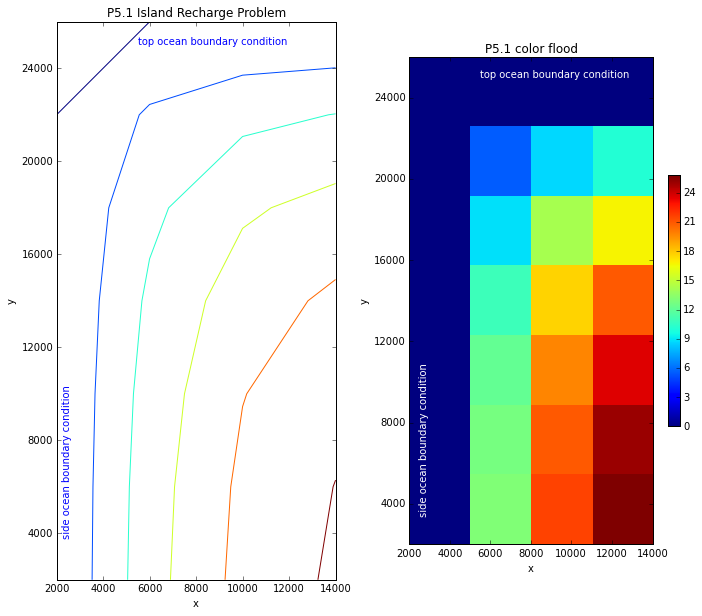

In [22]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(12,10))

#setup contour levels and plot extent
LEVELS = np.arange(0., 26., 5.)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 28000, 4000)
AX1.set_yticks(YTICKS)
AX1.set_title("P5.1 Island Recharge Problem")
AX1.text(2250, 10000, r"side ocean boundary condition", fontsize=10, color="blue", rotation='vertical')
AX1.text(5500, 25000, r"top ocean boundary condition", fontsize=10, color="blue")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("P5.1 color flood")
AX2.text(5500, 25000, r"top ocean boundary condition", fontsize=10, color="white")
AX2.text(2500, 10500, r"side ocean boundary condition", fontsize=10, color="white", rotation='vertical')
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest')
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)


In [23]:
print HEAD

[[[  0.           0.           0.           0.        ]
  [  0.           5.62512398   8.71148396  10.10727406]
  [  0.           8.90901184  14.23354053  16.73033714]
  [  0.          10.89738178  17.70332718  20.97019768]
  [  0.          12.09718895  19.83218956  23.59692764]
  [  0.          12.77918339  21.05131721  25.10839653]
  [  0.          13.08822632  21.60549736  25.79694748]]]


Look at the bottom of the MODFLOW output file (ending with a *.list) and write down the water balance reported to compare to the less coarse grid size done in the next part of the problem. 

## Changing the grid size and rerunning/plotting
Recall that the second part of Part b is to redo the problem with a finer grid spacing:  a 13 x 25 array of nodes (delta x = delta y= 1000 ft).


In [24]:
LX = 13000.   # same as before - half width of island + one node for constant head boundary condition
LY = 25000.   # same as before - half height of island + one node for constant head boundary condition
NLAY = 1
NROW = 25
NCOL = 13
DELR = LX / NCOL  # recall that MODFLOW convention is DELR is along a row, thus has items = NCOL; see page XXX in AW&H (2015)
DELC = LY / NROW  # recall that MODFLOW convention is DELC is along a column, thus has items = NROW; see page XXX in AW&H (2015)
DELV = (ZTOP - ZBOT) / NLAY
BOTM = np.linspace(ZTOP, ZBOT, NLAY + 1)
HK = 200.
VKA = 1.
RCH = 0.00305 
# WELLQ = 0.   #not needed for Problem 5.1
print "DELR =", DELR, "  DELC =", DELC, '  DELV =', DELV
print "BOTM =", BOTM
print "Recharge =", RCH 

DELR = 1000.0   DELC = 1000.0   DELV = 50.0
BOTM = [  0. -50.]
Recharge = 0.00305


In [25]:
# Create the discretization object
TOP = ZTOP * np.ones((NROW, NCOL),dtype=np.float)
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM[1:], laycbd=0)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...


In [26]:
# Variables for the BAS package
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int32)  # all nodes are active (IBOUND = 1)

# make the top of the profile specified head by setting the IBOUND = -1
IBOUND[:, 0, :] = -1  #don't forget arrays are zero-based! Sets first row
IBOUND[:, :, 0] = -1  # Sets first column
print IBOUND

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1]
  [-1  1  1

In [27]:
STRT = 1 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # set starting head to 1` through out model domain
STRT[:, 0, :] = 0.       # top row ocean elevation for setting constant head
STRT[:, :, 0] = 0.     # first column ocean elevation for setting constant head
print STRT

[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  

In [28]:
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


In [29]:
#delete earlier files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

Deleted:  P5-1.bas
Deleted:  P5-1.cbc
Deleted:  P5-1.ddn
Deleted:  P5-1.dis
Deleted:  P5-1.hds
Deleted:  P5-1.list
Deleted:  P5-1.lpf
Deleted:  P5-1.nam
Deleted:  P5-1.oc
Deleted:  P5-1.pcg
Deleted:  P5-1.rch


In [30]:
#Now write the model input files
MF.write_input()
# return current working directory
print "You can check the newly created files in", modelpath

You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_5_problems-1/P5-1_Island_recharge


In [31]:
#Run MODFLOW
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_5_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P5-1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/09/23 12:59:29

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/09/23 12:59:29
 Elapsed run time:  0.007 Seconds

  Normal termination of simulation


In [32]:
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times
#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Headfile (P5-1.hds) contains the following list of times:  [1.0]
Head statistics
  min:  0.0
  max:  21.5226
  std:  6.71904


Contour Levels:  [  0.   5.  10.  15.  20.  25.]
Extent of domain:  (500.0, 12500.0, 500.0, 24500.0)


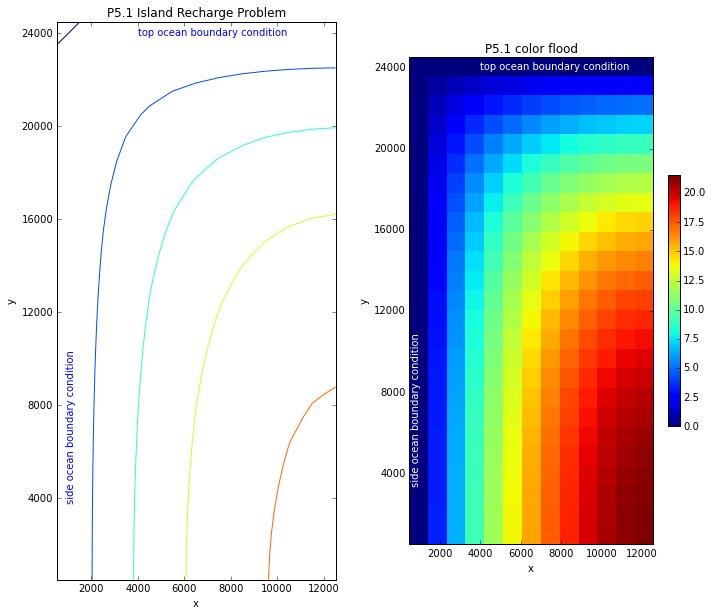

In [33]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(12,10))

#setup contour levels and plot extent
LEVELS = np.arange(0., 26., 5.)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 28000, 4000)
AX1.set_yticks(YTICKS)
AX1.set_title("P5.1 Island Recharge Problem")
AX1.text(900, 10000, r"side ocean boundary condition", fontsize=10, color="blue", rotation='vertical')
AX1.text(4000, 23900, r"top ocean boundary condition", fontsize=10, color="blue")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("P5.1 color flood")
AX2.text(4000, 23900, r"top ocean boundary condition", fontsize=10, color="white")
AX2.text(600, 10500, r"side ocean boundary condition", fontsize=10, color="white", rotation='vertical')
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest')
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

In [34]:
print HEAD

[[[  0.           0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.           0.
     0.        ]
  [  0.           0.60000247   1.047019     1.40084159   1.6893183
     1.92744803   2.1242485    2.28557014   2.41539431   2.51650047
     2.59083104   2.63970518   2.66394496]
  [  0.           1.0479908    1.88223183   2.56202936   3.12398338
     3.59122515   3.97897649   4.29763699   4.55450678   4.75477648
     4.90211821   4.9990449    5.04712963]
  [  0.           1.40472889   2.56688809   3.53606033   4.34836102
     5.02949238   5.59779501   6.06649542   6.44521952   6.74098063
     6.95881987   7.10222721   7.17339897]
  [  0.           1.69903684   3.13953114   4.3619628    5.39890814
     6.27558899   7.01121521   7.62032986   8.11389637   8.50010586
     8.78495502   8.97264385   9.06584072]
  [  0.           1.94688749   3.62523723   5.06835079   6.3047204
     7.35773993   8.24614716   8.9847126    9.58492947 

Write down the new mass balance information for this 1000 ft grid size run (or rename the *.list file).  Compare your previous result obtained with the 4000 foot grid size.

# P5.1 Part e.

Run your model with a nodal spacing of 500 ft and again with a nodal spacing of 250 ft. Compare head values and the volumetric discharge rate at the shoreline for all four nodal networks. Do you think a nodal spacing of 1000 ft is adequate for this problem? Justify your answer.

In [35]:
# Same as above but now 500 foot nodal spacing
LX = 12500.   # same as before - half width of island + one node for constant head boundary condition
LY = 24500.   # same as before - half height of island + one node for constant head boundary condition
NLAY = 1
NROW = 49
NCOL =25
DELR = LX / NCOL  # recall that MODFLOW convention is DELR is along a row, thus has items = NCOL; see page XXX in AW&H (2015)
DELC = LY / NROW  # recall that MODFLOW convention is DELC is along a column, thus has items = NROW; see page XXX in AW&H (2015)
DELV = (ZTOP - ZBOT) / NLAY
BOTM = np.linspace(ZTOP, ZBOT, NLAY + 1)
HK = 200.
VKA = 1.
RCH = 0.00305 
# WELLQ = 0.   #not needed for Problem 5.1
print "DELR =", DELR, "  DELC =", DELC, '  DELV =', DELV
print "BOTM =", BOTM
print "Recharge =", RCH 

DELR = 500.0   DELC = 500.0   DELV = 50.0
BOTM = [  0. -50.]
Recharge = 0.00305


In [36]:
# Create the discretization object
TOP = ZTOP * np.ones((NROW, NCOL),dtype=np.float)
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM[1:], laycbd=0)
# Variables for the BAS package
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int32)  # all nodes are active (IBOUND = 1)

# make the top of the profile specified head by setting the IBOUND = -1
IBOUND[:, 0, :] = -1  #don't forget arrays are zero-based! Sets first row
IBOUND[:, :, 0] = -1  # Sets first column
print IBOUND

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...
[[[-1 -1 -1 ..., -1 -1 -1]
  [-1  1  1 ...,  1  1  1]
  [-1  1  1 ...,  1  1  1]
  ..., 
  [-1  1  1 ...,  1  1  1]
  [-1  1  1 ...,  1  1  1]
  [-1  1  1 ...,  1  1  1]]]


In [37]:
STRT = 1 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # set starting head to 1` through out model domain
STRT[:, 0, :] = 0.       # top row ocean elevation for setting constant head
STRT[:, :, 0] = 0.     # first column ocean elevation for setting constant head
print STRT

[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  1.  1. ...,  1.  1.  1.]
  [ 0.  1.  1. ...,  1.  1.  1.]
  ..., 
  [ 0.  1.  1. ...,  1.  1.  1.]
  [ 0.  1.  1. ...,  1.  1.  1.]
  [ 0.  1.  1. ...,  1.  1.  1.]]]


In [38]:
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object
#delete earlier files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename
#Now write the model input files
MF.write_input()
# return current working directory
print "New files written. You can check them in", modelpath
#Run MODFLOW
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times
#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
Deleted:  P5-1.bas
Deleted:  P5-1.cbc
Deleted:  P5-1.ddn
Deleted:  P5-1.dis
Deleted:  P5-1.hds
Deleted:  P5-1.list
Deleted:  P5-1.lpf
Deleted:  P5-1.nam
Deleted:  P5-1.oc
Deleted:  P5-1.pcg
Deleted:  P5-1.rch
New files written. You can check them in /Users/rjhunt1/GitHub/Chapter_5_problems-1/P5-1_Island_recharge
FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_5_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P5-1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/09/23 12:59:30

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd 

Note that the max head is getting closer to the analytical solution of 20 ft.

Contour Levels:  [  0.   5.  10.  15.  20.  25.]
Extent of domain:  (250.0, 12250.0, 250.0, 24250.0)


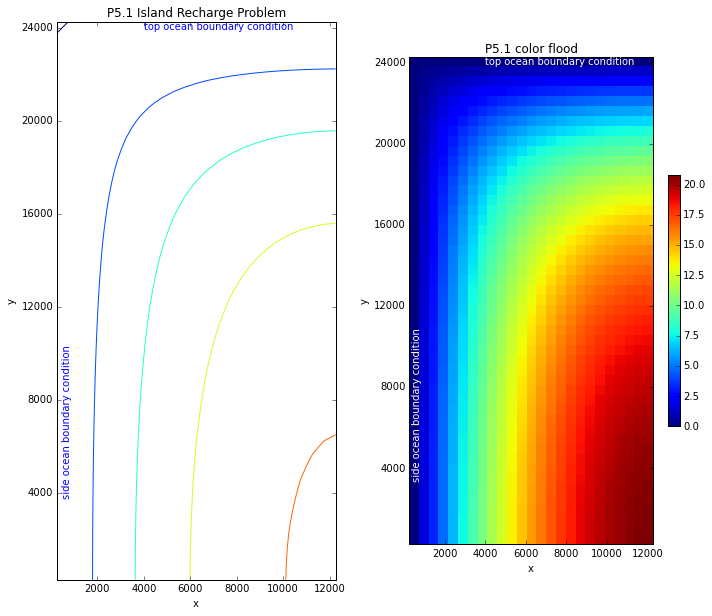

In [39]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(12,10))

#setup contour levels and plot extent
LEVELS = np.arange(0., 26., 5.)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 28000, 4000)
AX1.set_yticks(YTICKS)
AX1.set_title("P5.1 Island Recharge Problem")
AX1.text(500, 10000, r"side ocean boundary condition", fontsize=10, color="blue", rotation='vertical')
AX1.text(4000, 23900, r"top ocean boundary condition", fontsize=10, color="blue")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("P5.1 color flood")
AX2.text(4000, 23900, r"top ocean boundary condition", fontsize=10, color="white")
AX2.text(400, 10500, r"side ocean boundary condition", fontsize=10, color="white", rotation='vertical')
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest')
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

Again write down the mass balance information from the *.list file for comparison to other grid sizes.  

In [40]:
# Same as above but now 250 foot nodal spacing
LX = 12250.   # same as before - half width of island + one node for constant head boundary condition
LY = 24250.   # same as before - half height of island + one node for constant head boundary condition
NLAY = 1
NROW = 97
NCOL =49
DELR = LX / NCOL  # recall that MODFLOW convention is DELR is along a row, thus has items = NCOL; see page XXX in AW&H (2015)
DELC = LY / NROW  # recall that MODFLOW convention is DELC is along a column, thus has items = NROW; see page XXX in AW&H (2015)
DELV = (ZTOP - ZBOT) / NLAY
BOTM = np.linspace(ZTOP, ZBOT, NLAY + 1)
HK = 200.
VKA = 1.
RCH = 0.00305 
# WELLQ = 0.   #not needed for Problem 5.1
print "DELR =", DELR, "  DELC =", DELC, '  DELV =', DELV
print "BOTM =", BOTM
print "Recharge =", RCH 

DELR = 250.0   DELC = 250.0   DELV = 50.0
BOTM = [  0. -50.]
Recharge = 0.00305


In [41]:
# Create the discretization object
TOP = ZTOP * np.ones((NROW, NCOL),dtype=np.float)
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM[1:], laycbd=0)
# Variables for the BAS package
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int32)  # all nodes are active (IBOUND = 1)

# make the top of the profile specified head by setting the IBOUND = -1
IBOUND[:, 0, :] = -1  #don't forget arrays are zero-based! Sets first row
IBOUND[:, :, 0] = -1  # Sets first column
STRT = 1 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # set starting head to 1` through out model domain
STRT[:, 0, :] = 0.       # top row ocean elevation for setting constant head
STRT[:, :, 0] = 0.     # first column ocean elevation for setting constant head
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object
#delete earlier files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename
#Now write the model input files
MF.write_input()
# return current working directory
print "New files written. You can check them in", modelpath
#Run MODFLOW
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times
#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
Deleted:  P5-1.bas
Deleted:  P5-1.cbc
Deleted:  P5-1.ddn
Deleted:  P5-1.dis
Deleted:  P5-1.hds
Deleted:  P5-1.list
Deleted:  P5-1.lpf
Deleted:  P5-1.nam
Deleted:  P5-1.oc
Deleted:  P5-1.pcg
Deleted:  P5-1.rch
New files written. You can check them in /Users/rjhunt1/GitHub/Chapter_5_problems-1/P5-1_Island_recharge
FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_5_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P5-1.nam 
 Run start date and tim

Note that the max head is again getting closer to the analytical solution of 20 ft.

Contour Levels:  [  0.   5.  10.  15.  20.  25.]
Extent of domain:  (125.0, 12125.0, 125.0, 24125.0)


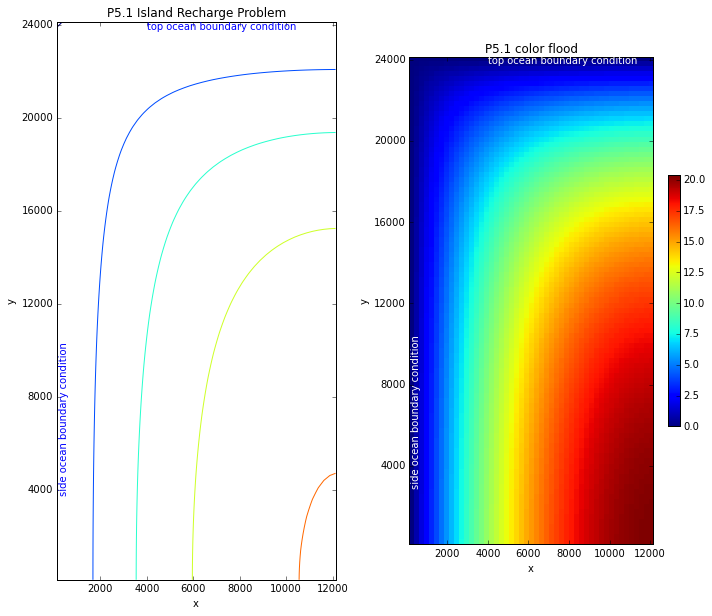

In [42]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(12,10))

#setup contour levels and plot extent
LEVELS = np.arange(0., 26., 5.)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 28000, 4000)
AX1.set_yticks(YTICKS)
AX1.set_title("P5.1 Island Recharge Problem")
AX1.text(220, 10000, r"side ocean boundary condition", fontsize=10, color="blue", rotation='vertical')
AX1.text(4000, 23800, r"top ocean boundary condition", fontsize=10, color="blue")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("P5.1 color flood")
AX2.text(4000, 23800, r"top ocean boundary condition", fontsize=10, color="white")
AX2.text(200, 10000, r"side ocean boundary condition", fontsize=10, color="white",rotation='vertical')
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest')
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

### Again write down the mass balance information from the *.list file for the 250 foot grid spacing. Compare all grid sizes.  